In [1]:
import re
import operator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from wordcloud import WordCloud
from visualization_methods import VisualizationMethods as vm
from aggregation_methods import AggregationMethods as am

df = pd.read_csv('django-packages.csv', sep=';')

categories = ['apps', 'frameworks']

removed_packages = [
    'wooey/Wooey', # Django app that creates automatic web UIs for Python scripts
    'django/django', # Django framework
    'gunthercox/ChatterBot', # ML conversational dialog engine for creating chatbots
    'mirumee/saleor', # ecommerce platform built on Django
]

df = df[~df['repo_id'].isin(removed_packages)]

# 'wagtail/wagtail' and 'django-fluent/django-fluent.org' are content management 
# systems built on Django which have a lot of packages and extensions
cms_reg = re.compile(r'.*((cms)|(wagtail)|((django)\-(fluent))|((django)\-(cms))).*', re.IGNORECASE)
df = df[~df['repo_id'].str.match(cms_reg, na=False)]
df = df[~df['dp_grids'].str.match(cms_reg, na=False)]
df = df[~df['repo_topics'].str.match(cms_reg, na=False)]

df = df[(df['has_valid_repo_url']) & (df['has_valid_repo'])]
df = df[df['dp_category'].isin(categories)]
# df = df[df['repo_last_commit_date'] >= '2018-01-01T00:00:00:000']
df = df[(df['repo_has_readme']) & (df['repo_has_installed_app_ref'])]

starts_median = 50 # np.median(np.array(df['repo_stars'].values))
df = df[df['repo_stars'] >= starts_median]

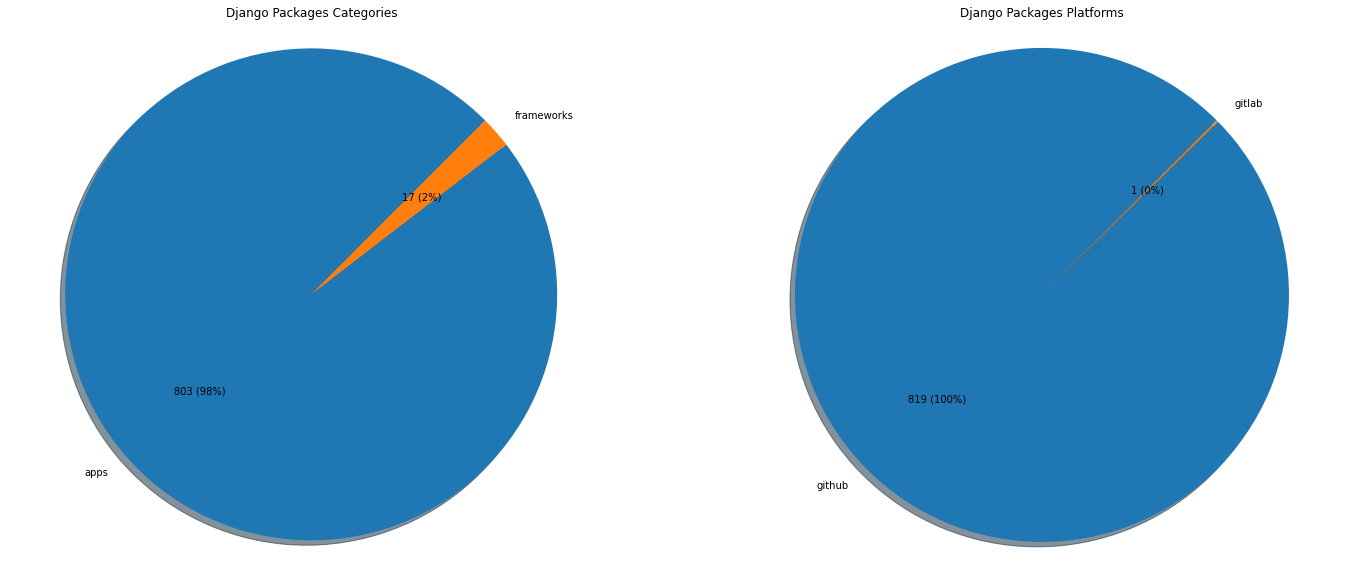

In [2]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
fig.set_facecolor('white')

categories = 'apps', 'frameworks'
platforms = 'github', 'gitlab'

sizes = [
    len(df[df['dp_category'] == categories[0]]),
    len(df[df['dp_category'] == categories[1]]),    
]

vm.set_pie_by_ax(ax1, sizes, categories, 'Django Packages Categories')

sizes = [
    len(df[df['platform'] == platforms[0]]),
    len(df[df['platform'] == platforms[1]]),    
]

vm.set_pie_by_ax(ax2, sizes, platforms, 'Django Packages Platforms')

plt.show()

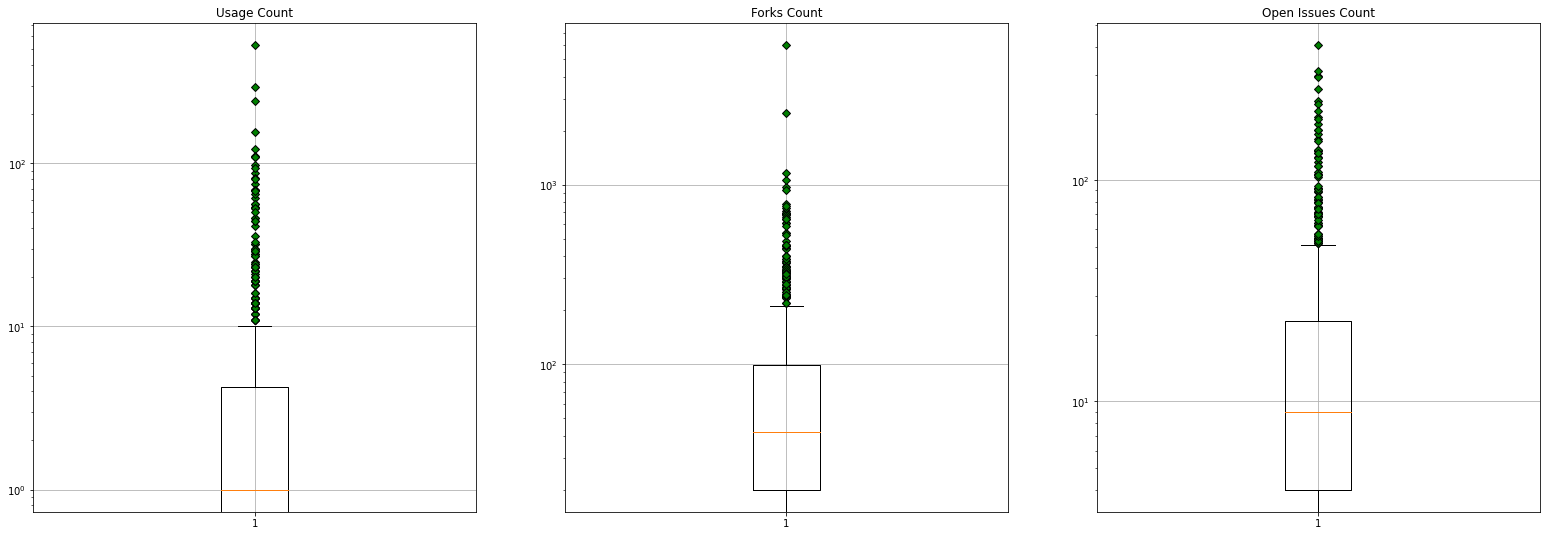

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(27, 9))

vm.set_boxplot_by_ax(ax1, df['dp_usage_count'].values, 'Usage Count', True)
vm.set_boxplot_by_ax(ax2, df['repo_forks'].values, 'Forks Count', True)
vm.set_boxplot_by_ax(ax3, df['repo_open_issues'].values, 'Open Issues Count', True)

plt.show()

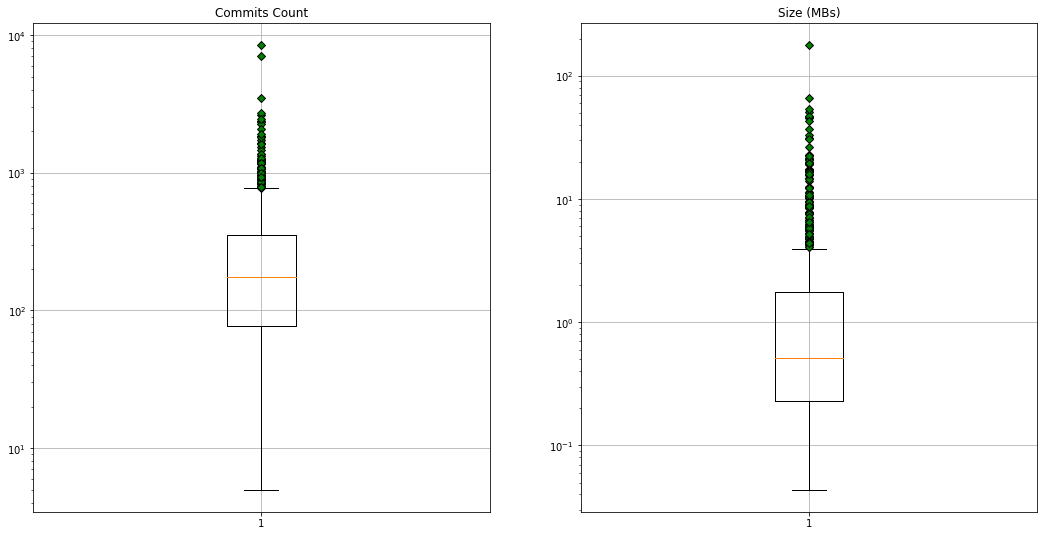

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

size_bytes = df['repo_size'].values
size_kbytes = [b/1000 for b in size_bytes]
size_mbytes = [b/1000 for b in size_kbytes]

vm.set_boxplot_by_ax(ax1, df['repo_commits'].values, 'Commits Count', True)
vm.set_boxplot_by_ax(ax2, size_mbytes, 'Size (MBs)', True)

plt.show()

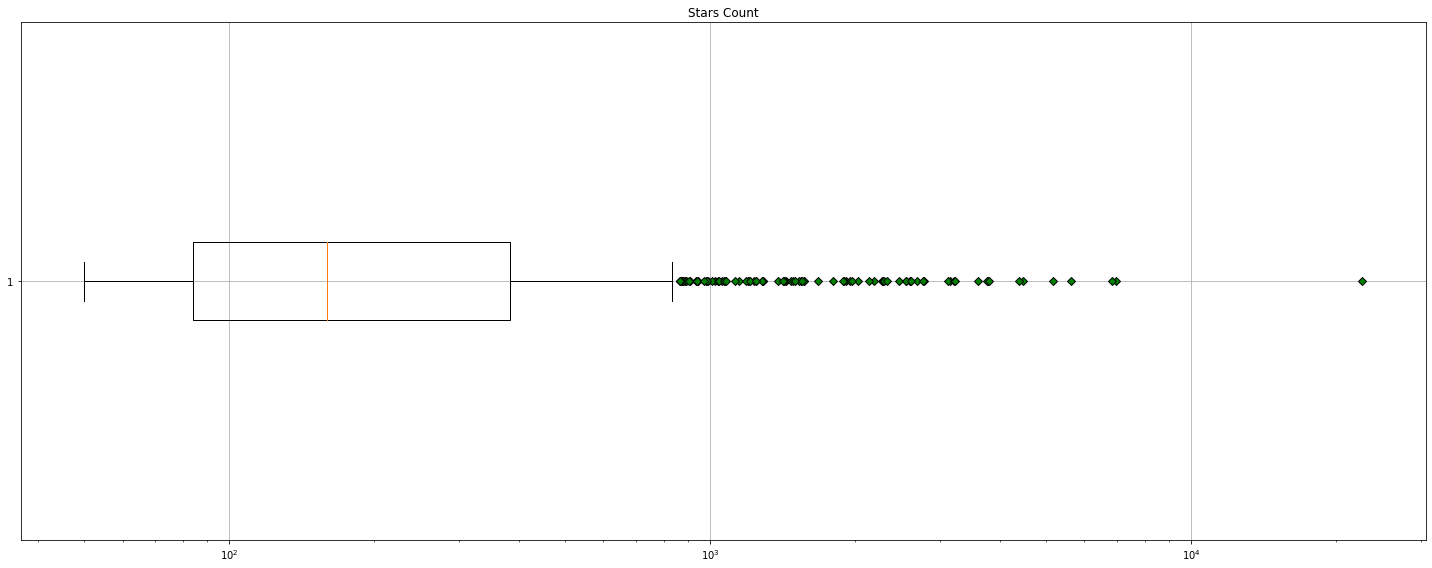

In [5]:
fig, ax = plt.subplots(figsize=(20, 8))

vm.set_boxplot_by_ax(ax, df['repo_stars'].values, 'Stars Count', True, True)

plt.tight_layout()
plt.show()

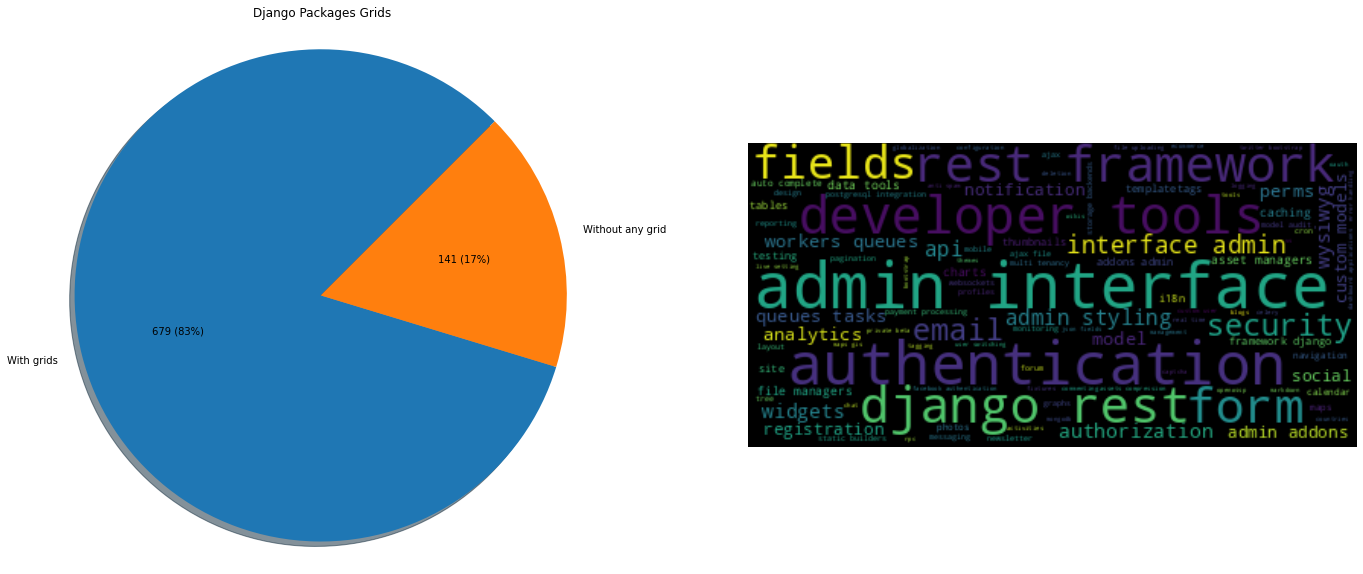

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
fig.set_facecolor('white')

labels = 'With grids', 'Without any grid'

sizes = [
    len(df[~df['dp_grids'].isnull()]),
    len(df[df['dp_grids'].isnull()]),
]

vm.set_pie_by_ax(ax1, sizes, labels, 'Django Packages Grids')

grid_concate, grids_freq = am.get_concate_and_freq(df[~df['dp_grids'].isnull()]['dp_grids'].values)

ax2.imshow(WordCloud().generate(grid_concate), interpolation='bilinear')
ax2.axis("off")

plt.show()

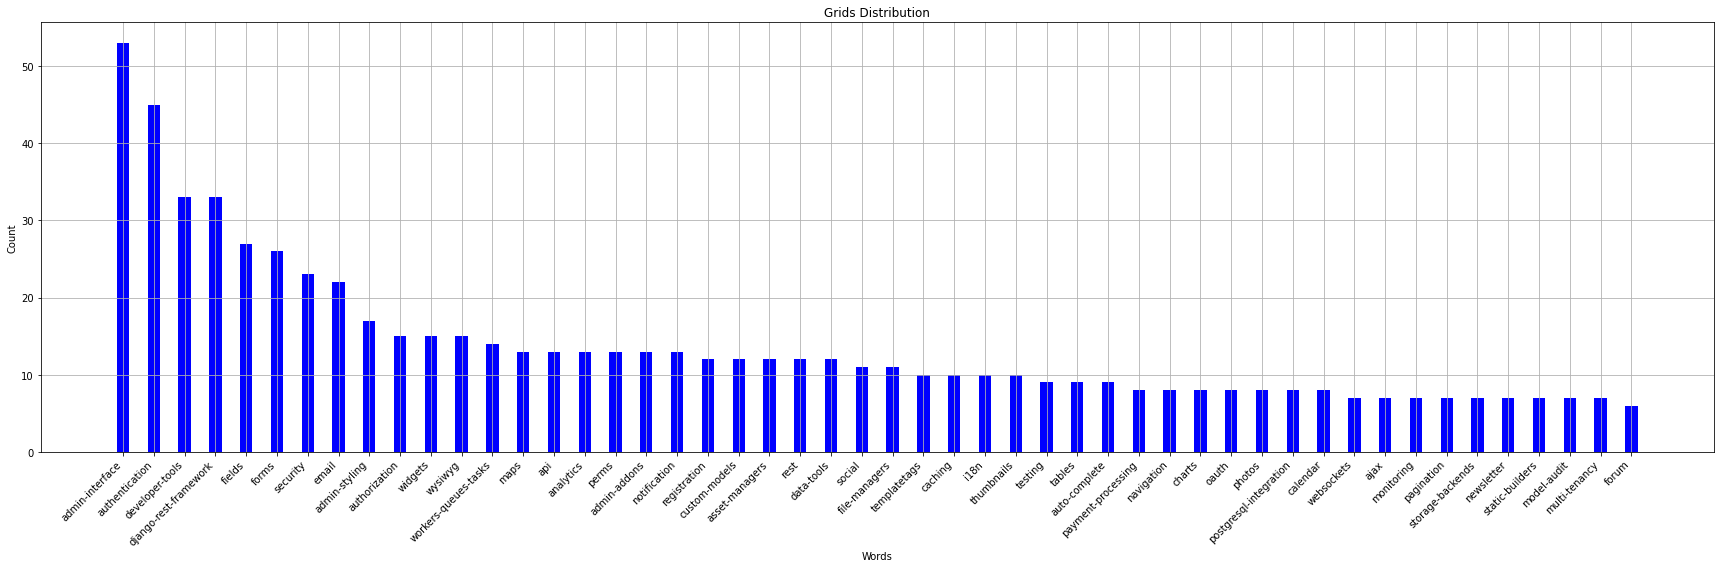

In [7]:
top = 50
top_grid_freq = {k[0]: k[1] for k in sorted(grids_freq.items(), key=operator.itemgetter(1), reverse=True)[:top]}

vm.show_bar_chart_by_dict(top_grid_freq, 'Words', 'Count', 'Grids Distribution', 'blue')

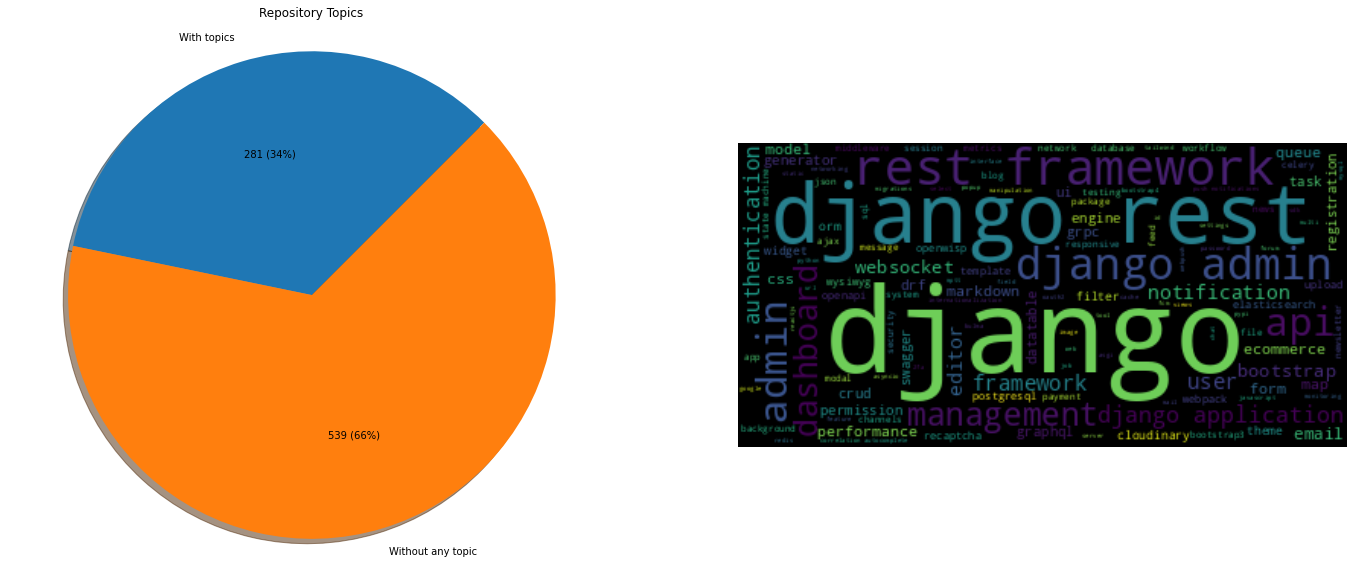

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
fig.set_facecolor('white')

labels = 'With topics', 'Without any topic'

sizes = [
    len(df[~df['repo_topics'].isnull()]),
    len(df[df['repo_topics'].isnull()]),
]

vm.set_pie_by_ax(ax1, sizes, labels, 'Repository Topics')

unwanted_topics = [ 'django' ]
unwanted_regex = [ 
    re.compile(r'^(python)((\d+)|(\-.*)|\Z)', re.IGNORECASE), 
    re.compile(r'^(hacktoberfest)((\-\d+)|(\d+)|\Z)', re.IGNORECASE)
]

topics_concate, topics_freq = am.get_concate_and_freq(
    df[~df['repo_topics'].isnull()]['repo_topics'].values, 
    unwanted_topics, 
    unwanted_regex
)

ax2.imshow(WordCloud().generate(topics_concate), interpolation='bilinear')
ax2.axis("off")

plt.show()

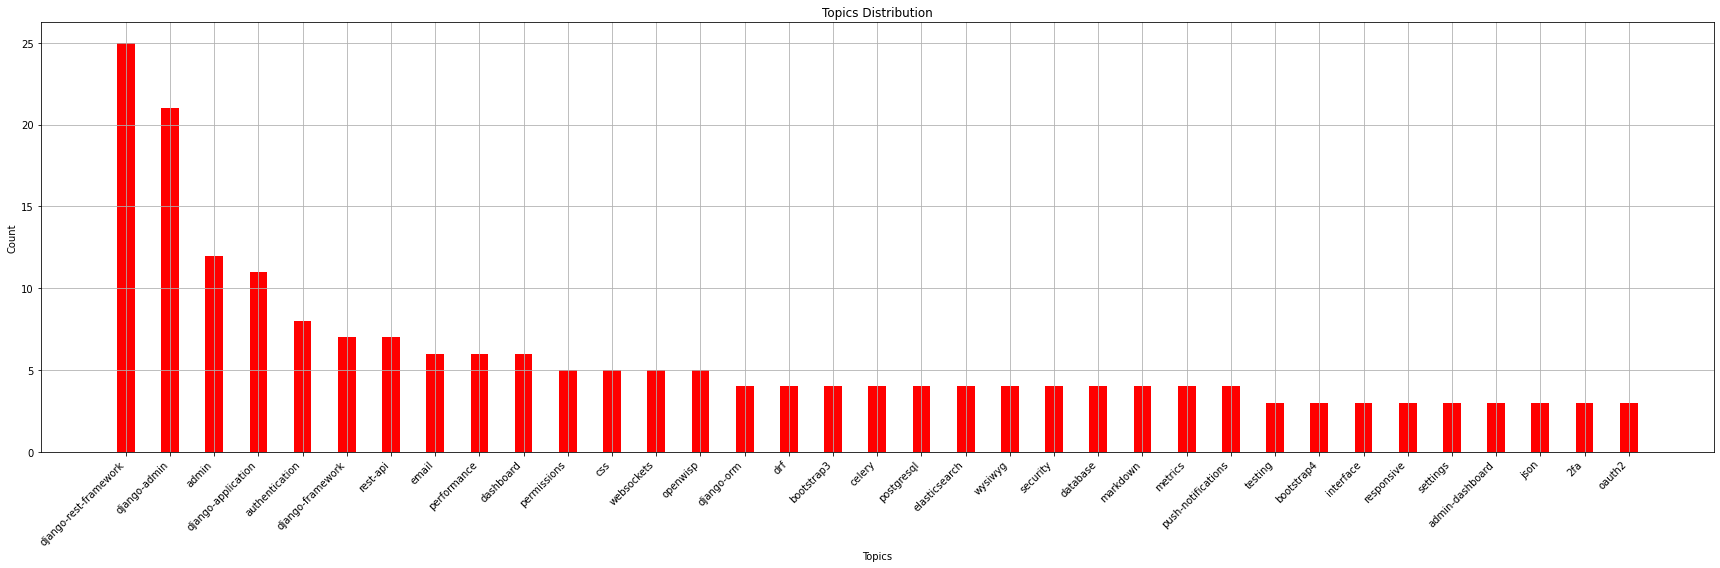

In [9]:
top = 35
top_repo_freq = {k[0]: k[1] for k in sorted(topics_freq.items(), key=operator.itemgetter(1), reverse=True)[:top]}

vm.show_bar_chart_by_dict(top_repo_freq, 'Topics', 'Count', 'Topics Distribution', 'red')